In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import re
import warnings
warnings.filterwarnings('ignore')



ag_all_bh = pd.read_csv('Datasets/ag_all_bh.csv')
ag_col_bh = pd.read_csv('Datasets/ag_col_bh.csv')
ag_merge_bh = pd.read_csv('Datasets/ag_merge_bh.csv')
ag_col = pd.read_csv('Datasets/ag_col.csv')
ag_merge = pd.read_csv('Datasets/ag_merge.csv')
model_list = pd.read_csv('Datasets/model_list.csv')

# importing the data form csvs

In [4]:
ag_col_bh

,time_x,collision_type,idm,mm,id1,m1,id2,m2,r_x,typem,...,r_y,binary,ID,zams_m,m_progenitor,bh_mass,bh_spin,birth_kick,bbh_merger,model
0,11.565179,single-single,1680002,33.8986,1680001,33.7704,470820,0.129842,0.038822,4,...,0.191185,0,1680002,0.000000,17.89330,16.09650,0.0,1.00000,0,data\N16rv0.5rg2.0Z0.002
1,7.978654,single-single,1680061,133.8740,1680060,179.9130,299190,0.394966,0.013368,4,...,0.137582,1,1680061,0.000000,33.00390,29.70350,0.0,0.00000,0,data\N16rv0.5rg2.0Z0.002
2,3.710148,single-single,1680133,110.5980,1680132,110.4200,261872,0.179723,0.025530,4,...,0.144856,1,1680133,0.000000,35.19190,31.67270,0.0,0.00000,0,data\N16rv0.5rg2.0Z0.002
3,4.100341,single-single,1680220,41.3707,1680219,41.2697,328483,0.105145,0.052498,4,...,0.069415,0,1680220,0.341818,34.12200,30.70980,0.0,1.00000,0,data\N16rv0.5rg2.0Z0.002
4,3.849036,single-single,1680292,52.0011,1680291,51.8734,137163,0.133144,0.041029,4,...,0.034394,0,1680292,0.169725,40.61420,36.55280,0.0,1.00000,1,data\N16rv0.5rg2.0Z0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25558,7.467068,single-single,867397,27.4788,27397,27.2059,34148,0.274166,0.809076,4,...,0.809076,0,867397,1.377720,29.83110,12.91490,0.0,196.38100,0,data\N8.0rv4.0rg8.0Z0.002
25559,8.195550,single-single,935010,21.1569,95010,21.0637,260784,0.094146,1.787344,4,...,1.787344,0,935010,0.376952,29.08860,11.89070,0.0,89.37041,0,data\N8.0rv4.0rg8.0Z0.002
25560,8.195550,single-single,1021125,23.4548,239877,23.3603,181125,0.095204,2.219268,4,...,2.219268,0,1021125,0.000000,28.60760,11.48710,0.0,149.45210,0,data\N8.0rv4.0rg8.0Z0.002
25561,6.479118,single-single,901838,26.2744,61838,26.0639,69692,0.210457,0.995484,1,...,1.914572,0,901838,58.609600,8.76791,7.63069,0.0,1.00000,0,data\N8.0rv4.0rg8.0Z0.02


## Grouping 

## multiindex data frame test

In [5]:
ag_col_bh['int_type'] = pd.Categorical(
    np.select([
        (ag_col_bh['type1'].isin([0,1]) & ag_col_bh['type2'].isin([0,1])),
        (ag_col_bh['type1'].isin(range(2,10)) & ag_col_bh['type2'].isin(range(2,10))),
        ((ag_col_bh['type1'].isin([0,1]) & ag_col_bh['type2'].isin(range(2,10))) | 
         (ag_col_bh['type1'].isin(range(2,10)) & ag_col_bh['type2'].isin([0,1]))),
        ((ag_col_bh['type1'] >= 10) | (ag_col_bh['type2'] >= 10))
    ], ['MS+MS', 'Giant+Giant', 'MS+Giant', 'Other'], default='Unknown'),
    categories=['MS+MS', 'MS+Giant', 'Giant+Giant', 'Other', 'Unknown'],
    ordered=True
)


In [6]:
df_processed = ag_col_bh.copy()

# Mass ratio categories
df_processed['q'] = pd.cut(
    df_processed['mass_ratio'], 
    bins=[0, 0.01, 0.1, 1.0], 
    labels=['0.01', '0.1', '1'],
    include_lowest=True
)

# Type categories
df_processed['type'] = df_processed['typem'].apply(
    lambda x: 'MS' if x in [0, 1] else 'Giant' if x in [2, 3, 4, 5, 6, 7, 8, 9] else 'Other'
)

# Larger mass categories
df_processed['pm'] = pd.cut(
    df_processed['larger_mass'], 
    bins=[0,10, 50, 100, 150], 
    labels=['10','50', '100', '150'],
    include_lowest=True
)

# Create MultiIndex DataFrame
col = df_processed.set_index(['q', 'type', 'pm','int_type'])
col

time_x collision_type      idm        mm      id1  \
q    type  pm  int_type                                                         
0.01 Giant 50  MS+Giant  11.565179  single-single  1680002   33.8986  1680001   
           nan MS+Giant   7.978654  single-single  1680061  133.8740  1680060   
           150 MS+Giant   3.710148  single-single  1680133  110.5980  1680132   
           50  MS+Giant   4.100341  single-single  1680220   41.3707  1680219   
           100 MS+Giant   3.849036  single-single  1680292   52.0011  1680291   
...                            ...            ...      ...       ...      ...   
0.1  Giant 50  MS+Giant   7.467068  single-single   867397   27.4788    27397   
0.01 Giant 50  MS+Giant   8.195550  single-single   935010   21.1569    95010   
               MS+Giant   8.195550  single-single  1021125   23.4548   239877   
     MS    50  MS+MS      6.479118  single-single   901838   26.2744    61838   
     Giant 50  MS+Giant   5.730905  single-single   979285   31.3418   220037   

                               m1     id2        m2       r_x  typem  ...  \
q    type  pm  int_type                                               ...   
0.01 Giant 50  MS+Giant   33.7704  470820  0.129842  0.038822      4  ...   
           nan MS+Giant  179.9130  299190  0.394966  0.013368      4  ...   
           150 MS+Giant  110.4200  261872  0.179723  0.025530      4  ...   
           50  MS+Giant   41.2697  328483  0.105145  0.052498      4  ...   
           100 MS+Giant   51.8734  137163  0.133144  0.041029      4  ...   
...                           ...     ...       ...       ...    ...  ...   
0.1  Giant 50  MS+Giant   27.2059   34148  0.274166  0.809076      4  ...   
0.01 Giant 50  MS+Giant   21.0637  260784  0.094146  1.787344      4  ...   
               MS+Giant   23.3603  181125  0.095204  2.219268      4  ...   
     MS    50  MS+MS      26.0639   69692  0.210457  0.995484      1  ...   
     Giant 50  MS+Giant   31.2379  139285  0.104337  2.409768      4  ...   

                              r_y  binary       ID     zams_m  m_progenitor  \
q    type  pm  int_type                                                       
0.01 Giant 50  MS+Giant  0.191185       0  1680002   0.000000      17.89330   
           nan MS+Giant  0.137582       1  1680061   0.000000      33.00390   
           150 MS+Giant  0.144856       1  1680133   0.000000      35.19190   
           50  MS+Giant  0.069415       0  1680220   0.341818      34.12200   
           100 MS+Giant  0.034394       0  1680292   0.169725      40.61420   
...                           ...     ...      ...        ...           ...   
0.1  Giant 50  MS+Giant  0.809076       0   867397   1.377720      29.83110   
0.01 Giant 50  MS+Giant  1.787344       0   935010   0.376952      29.08860   
               MS+Giant  2.219268       0  1021125   0.000000      28.60760   
     MS    50  MS+MS     1.914572       0   901838  58.609600       8.76791   
     Giant 50  MS+Giant  1.671008       0   979285   0.000000       9.91991   

                          bh_mass  bh_spin  birth_kick  bbh_merger  \
q    type  pm  int_type                                              
0.01 Giant 50  MS+Giant  16.09650      0.0     1.00000           0   
           nan MS+Giant  29.70350      0.0     0.00000           0   
           150 MS+Giant  31.67270      0.0     0.00000           0   
           50  MS+Giant  30.70980      0.0     1.00000           0   
           100 MS+Giant  36.55280      0.0     1.00000           1   
...                           ...      ...         ...         ...   
0.1  Giant 50  MS+Giant  12.91490      0.0   196.38100           0   
0.01 Giant 50  MS+Giant  11.89070      0.0    89.37041           0   
               MS+Giant  11.48710      0.0   149.45210           0   
     MS    50  MS+MS      7.63069      0.0     1.00000           0   
     Giant 50  MS+Giant   6.05481      0.0   257.86510           0   

                                 

In [7]:
q_list = ['0.01', '0.1', '1']
type_list=['MS','Giant']
pm_list= ['10','50', '100', '150']
int_list=['MS+MS', 'MS+Giant', 'Giant+Giant', 'Other', 'Unknown']
groups = {}
names = []

# # Mass ratio and type m filtering
# for q in q_list:
#     for type in type_list:
#         variable_name = f"col_{q}_{type}"
#         names.append(variable_name)
#         groups[variable_name] = col.loc[q,type,:,:]

# # Mass ratio and interaction type filtering
# for q in q_list:
#     for int in int_list:
#         variable_name = f"col_{q}_{int}"
#         names.append(variable_name)
#         groups[variable_name] = col.loc[q,:,:,int]


# Only interaction type filtering

for int in int_list:
    variable_name = f"col_{int}"
    names.append(variable_name)
    groups[variable_name] = col.loc[:,:,:,int]

        


In [8]:
def sumarise_col(cluster_data):
        col_stats={
        'count': len(cluster_data),
        'percentage': len(cluster_data) / len(col) * 100,
        'avg_smaller_mass': cluster_data['smaller_mass'].mean(),
        'avg_larger_mass': cluster_data['larger_mass'].mean(),
        'avg_mass_ratio': cluster_data['mass_ratio'].mean(),
        'avg_merged_mass': cluster_data['mm'].mean(),
        'median_smaller_mass': cluster_data['smaller_mass'].median(),
        'median_larger_mass': cluster_data['larger_mass'].median(),
        'median_mass_ratio': cluster_data['mass_ratio'].median(),
        'median_merged_mass': cluster_data['mm'].median()

        }

        print("-" * 25) 

        for k, v in col_stats.items():
             print(f"{k:<10} {v:<15}")
        print("-" * 25) 
        return col_stats



In [9]:
groups[names[0]]

time_x collision_type      idm        mm      id1  \
q    type  pm                                                          
0.01 MS    100   3.101171  binary-single  1689424   91.6353     9424   
     Giant nan   7.696773  binary-single  1690159  339.8860  3387872   
     MS    150   6.892310  single-single  1692519  116.2320  1692518   
           100  10.072809  binary-single  1699097   83.2637  1744929   
           100   7.483465  binary-single  1706983   94.8166  1706982   
...                   ...            ...      ...       ...      ...   
0.1  MS    50    3.199974  single-single  1197979   21.6682   499712   
0.01 MS    50    3.670268  single-single   846409   46.5644     6409   
           150   1.955391  binary-single   850657  102.5440    10657   
           150   1.629516  single-single  1028351  107.5480   188351   
           50    6.479118  single-single   901838   26.2744    61838   

                      m1      id2        m2       r_x  typem  ...       r_y  \
q    type  pm                                                 ...             
0.01 MS    100   91.5253   348419  0.109969  0.018274      1  ...  0.080643   
     Giant nan  340.8549   281370  0.336668  0.021633      4  ...  0.017770   
     MS    150  116.0870  1092822  0.145747  0.039486      1  ...  0.037041   
           100   83.1649    19096  0.098736  0.060115      1  ...  0.071137   
           100   94.0114   359722  0.805201  0.056570      1  ...  0.171196   
...                  ...      ...       ...       ...    ...  ...       ...   
0.1  MS    50    20.7715   357979  0.896735  3.011356      1  ...  4.594240   
0.01 MS    50    46.3995   186356  0.164946  2.474312      1  ...  0.343672   
           150  102.4460    12219  0.097755  0.613264      1  ...  0.660296   
           150  107.4230   215425  0.125133  2.824044      1  ...  4.416080   
           50    26.0639    69692  0.210457  0.995484      1  ...  1.914572   

                binary       ID     zams_m  m_progenitor   bh_mass  bh_spin  \
q    type  pm                                                                 
0.01 MS    100       0  1689424   0.160949      31.88100  28.69290      0.0   
     Giant nan       1  1690159   0.000000      33.65450  30.28900      0.0   
     MS    150       0  1692519   0.127146      36.38780  32.74900      0.0   
           100       1  1699097   0.000000      28.77680  25.89910      0.0   
           100       0  1706983   0.106141      33.00080  29.70070      0.0   
...                ...      ...        ...           ...       ...      ...   
0.1  MS    50        0  1197979   0.000000      21.53020  16.77540      0.0   
0.01 MS    50        0   846409   0.000000      10.73270   6.66235      0.0   
           150       1   850657   0.000000      40.87930  36.79140      0.0   
           150       0  1028351   0.000000     104.15100  40.50000      0.0   
           50        0   901838  58.609600       8.76791   7.63069      0.0   

                birth_kick  bbh_merger                       model  
q    type  pm                                                       
0.01 MS    100     1.00000           0    data\N16rv0.5rg2.0Z0.002  
     Giant nan     0.00000           0    data\N16rv0.5rg2.0Z0.002  
     MS    150     1.00000           1    data\N16rv0.5rg2.0Z0.002  
           100     0.00000           0    data\N16rv0.5rg2.0Z0.002  
           100     1.00000           0    data\N16rv0.5rg2.0Z0.002  
...                    ...         ...                         ...  
0.1  MS    50      1.00000           0   data\N8.0rv4.0rg2.0Z0.002  
0.01 MS    50     93.37391           0    data\N8.0rv4.0rg2.0Z0.02  
           150     0.00000           0  data\N8.0rv4.0rg20.0Z0.002  
           150     1.00000           0  data\N8.0rv4.0rg8.0Z0.0002  
           50      1.00000           0    data\N8.0rv4.0rg8.0Z0.02  

[3230 rows x 26 columns]

In [10]:
group_list=[]
for name in names:

    print(f'Group params {name}')
    group_list.append(sumarise_col(groups[name].copy())
)


Group params col_MS+MS
-------------------------
count      3230           
percentage 12.635449673356023
avg_smaller_mass 0.8255666709597522
avg_larger_mass 60.308453494891644
avg_mass_ratio 0.02059849000590572
avg_merged_mass 60.915019845201236
median_smaller_mass 0.20059500000000002
median_larger_mass 52.2094        
median_mass_ratio 0.00398841961041065
median_merged_mass 52.64295       
-------------------------
Group params col_MS+Giant
-------------------------
count      22261          
percentage 87.08289324414193
avg_smaller_mass 0.6717811979201292
avg_larger_mass 34.16353480280311
avg_mass_ratio 0.023201413725984218
avg_merged_mass 34.04655150577242
median_smaller_mass 0.208895       
median_larger_mass 26.1557        
median_mass_ratio 0.0074755380619702
median_merged_mass 26.3688        
-------------------------
Group params col_Giant+Giant
-------------------------
count      58             
percentage 0.22689042757109887
avg_smaller_mass 23.08787172413793
avg_larger_mas

# groups summarised

In [11]:
group_sum = pd.DataFrame(group_list)
group_sum= group_sum.set_axis(names).round(3)
group_sum

,count,percentage,avg_smaller_mass,avg_larger_mass,avg_mass_ratio,avg_merged_mass,median_smaller_mass,median_larger_mass,median_mass_ratio,median_merged_mass
col_MS+MS,3230,12.635,0.826,60.308,0.021,60.915,0.201,52.209,0.004,52.643
col_MS+Giant,22261,87.083,0.672,34.164,0.023,34.047,0.209,26.156,0.007,26.369
col_Giant+Giant,58,0.227,23.088,36.518,0.718,58.846,19.631,30.100,0.767,46.013
col_Other,3,0.012,1.190,12.853,0.096,14.037,1.182,12.880,0.088,14.014
col_Unknown,11,0.043,0.213,136.411,0.002,113.876,0.195,136.050,0.002,125.215


# groups sumarised for a col_bh --- > bbh merger

In [12]:
group_list_bbh=[]
for name in names:

    print(f'Group params {name}')
    groups_bbh = groups[name].copy()
    groups_bbh = groups_bbh[groups_bbh['bbh_merger']==1]
    group_list_bbh.append(sumarise_col(groups_bbh.copy())
)


Group params col_MS+MS
-------------------------
count      492            
percentage 1.9246567304307005
avg_smaller_mass 0.8060337221544716
avg_larger_mass 72.07844835548781
avg_mass_ratio 0.015935761795932233
avg_merged_mass 72.44048922764227
median_smaller_mass 0.19026900000000002
median_larger_mass 68.90025       
median_mass_ratio 0.00318840931339855
median_merged_mass 70.01135       
-------------------------
Group params col_MS+Giant
-------------------------
count      3699           
percentage 14.47013261354301
avg_smaller_mass 0.7640351174641794
avg_larger_mass 42.8525059162206
avg_mass_ratio 0.020855390231880853
avg_merged_mass 42.378583300892124
median_smaller_mass 0.213907       
median_larger_mass 35.1058        
median_mass_ratio 0.0064050344789249
median_merged_mass 35.3428        
-------------------------
Group params col_Giant+Giant
-------------------------
count      13             
percentage 0.050854751007315256
avg_smaller_mass 29.33153076923077
avg_larger_mas

In [13]:

group_sum_bbh = pd.DataFrame(group_list_bbh)
group_sum_bbh= group_sum_bbh.set_axis(names).round(3)
group_sum_bbh

,count,percentage,avg_smaller_mass,avg_larger_mass,avg_mass_ratio,avg_merged_mass,median_smaller_mass,median_larger_mass,median_mass_ratio,median_merged_mass
col_MS+MS,492,1.925,0.806,72.078,0.016,72.440,0.190,68.900,0.003,70.011
col_MS+Giant,3699,14.470,0.764,42.853,0.021,42.379,0.214,35.106,0.006,35.343
col_Giant+Giant,13,0.051,29.332,44.617,0.777,72.980,27.728,35.960,0.856,58.636
col_Other,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
col_Unknown,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# groups plotted

## median line and point func def

In [14]:
def median_line(col_plot):
        median_mass_ratio_overall = col_plot['mass_ratio'].median()
        
        x_min = col_plot['smaller_mass'].min()
        x_max = col_plot['smaller_mass'].max()
        y_min = col_plot['larger_mass'].min()
        y_max = col_plot['larger_mass'].max()
        
        # Create x range for the line
        x_range = np.logspace(np.log10(x_min), np.log10(x_max), 100)
        y_line = x_range / median_mass_ratio_overall
        
        # LIMIT the line 
        mask = (y_line >= y_min) & (y_line <= y_max)
        x_line_limited = x_range[mask]
        y_line_limited = y_line[mask]
        
        plt.plot(x_line_limited, y_line_limited, 'k-', linewidth=2, label=f'Median Mass Ratio = {median_mass_ratio_overall:.3f}', zorder=4)

In [15]:
# def median_point(df, color='red', label='Median ± 1σ', zorder=5):
#     """Plot median point with error bars using standard deviation"""
#     med_smaller = df['smaller_mass'].median()
#     med_larger = df['larger_mass'].median()
#     std_smaller = df['smaller_mass'].std()
#     std_larger = df['larger_mass'].std()
    
#     plt.errorbar(med_smaller, med_larger, 
#                  xerr=std_smaller, yerr=std_larger,
#                  fmt='o', color=color, ecolor=color, 
#                  elinewidth=2, capsize=4, markersize=8,
#                  label=label, zorder=zorder)
    
def median_point(df, color='black', label='Median ± IQR', zorder=5):
    med_smaller = df['smaller_mass'].median()
    med_larger = df['larger_mass'].median()
    #using quartiles since std tends to get distorted in the graph
    q25_smaller = df['smaller_mass'].quantile(0.25)
    q75_smaller = df['smaller_mass'].quantile(0.75)
    q25_larger = df['larger_mass'].quantile(0.25)
    q75_larger = df['larger_mass'].quantile(0.75)

    xerr_lower = med_smaller - q25_smaller
    xerr_upper = q75_smaller - med_smaller
    yerr_lower = med_larger - q25_larger
    yerr_upper = q75_larger - med_larger

     # Print the median and error bar values
    print(f"Smaller mass median: {med_smaller:.3f}, Lower error: {xerr_lower:.3f}, Upper error: {xerr_upper:.3f}")
    print(f"Larger mass median: {med_larger:.3f}, Lower error: {yerr_lower:.3f}, Upper error: {yerr_upper:.3f}")

    plt.errorbar(med_smaller, med_larger, 
                    xerr=[[xerr_lower], [xerr_upper]], 
                    yerr=[[yerr_lower], [yerr_upper]],
                    fmt='o', color=color, ecolor=color, 
                    elinewidth=2, capsize=4, markersize=8,
                    label=label, zorder=zorder)



#  overall median group plots

In [16]:
sizes=1
alphas=1

Smaller mass median: 0.190, Lower error: 0.069, Upper error: 0.207
Larger mass median: 68.900, Lower error: 25.335, Upper error: 27.901


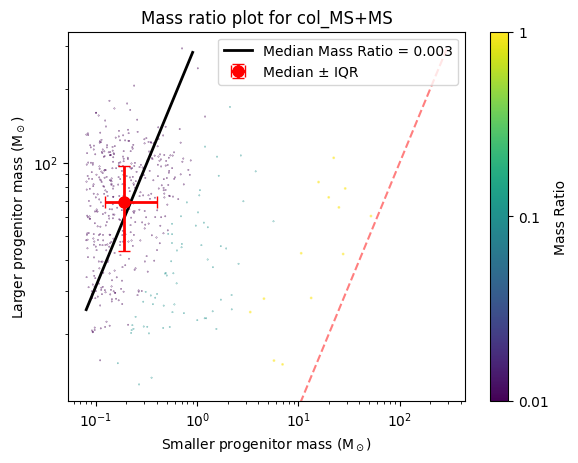

Smaller mass median: 0.214, Lower error: 0.087, Upper error: 0.225
Larger mass median: 35.106, Lower error: 12.412, Upper error: 21.139


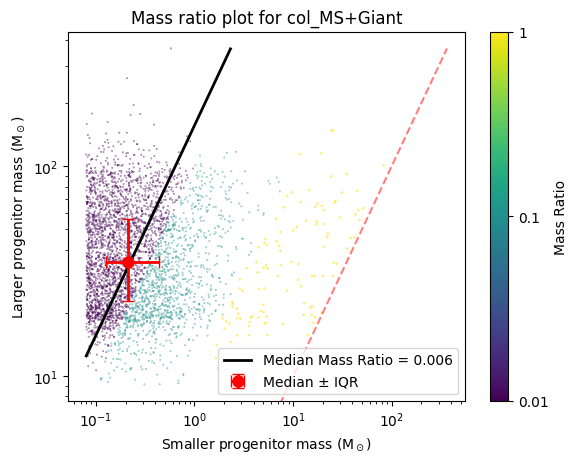

Smaller mass median: 27.728, Lower error: 14.979, Upper error: 6.504
Larger mass median: 35.960, Lower error: 17.726, Upper error: 25.547


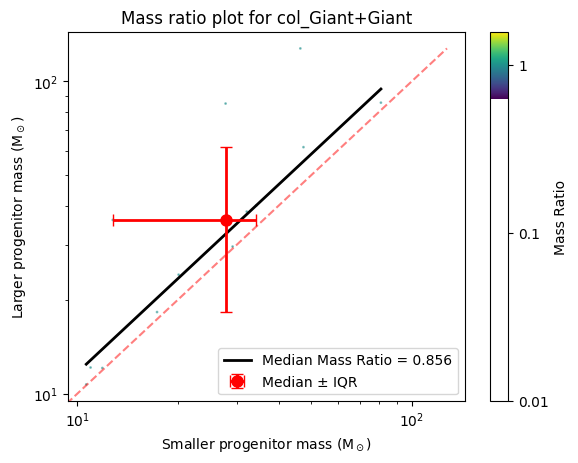

In [17]:
for name in names[:3]:
    col_plot = groups[name].copy()
    col_plot = col_plot[col_plot['bbh_merger']==1] 
    plt.figure()
    col_plot = col_plot.reset_index()
    
    # Create categorical bins
    col_plot['q'] = pd.cut(
        col_plot['mass_ratio'], 
        bins=[0, 0.01, 0.1, 1.0], 
        labels=['0.01', '0.1', '1'],
        include_lowest=True
    )
    
    # Create conditional size and alpha arrays based on smaller_mass
    sizes = np.where(col_plot['mass_ratio'] < 0.1, 0.05, 1)  
    alphas = np.where(col_plot['mass_ratio'] < 0.1, 1, 0.5)  
    
    # Convert categorical to numerical codes 
    sc = plt.scatter(col_plot['smaller_mass'], col_plot['larger_mass'], 
                     c=col_plot['q'].cat.codes, cmap='viridis', 
                     s=sizes, alpha=alphas)
    
    maxi = col_plot['larger_mass'].max()
    plt.plot([0,maxi],[0,maxi],'r--',alpha=.5)
    
    # Create colorbar labels
    cb = plt.colorbar(sc)
    cb.set_label('Mass Ratio')
    cb.set_ticks([0, 1, 2])  
    cb.set_ticklabels(['0.01', '0.1', '1'])

    #making over all median line and pont
    median_line(col_plot)
    median_point(col_plot, color='red')
    
    plt.xlabel('Smaller progenitor mass (M$_\odot$)')
    plt.ylabel('Larger progenitor mass (M$_\odot$)')
    plt.yscale('log')
    plt.xscale('log')
    plt.title(f'Mass ratio plot for {name}')
    plt.legend()
    plt.show()


Smaller mass median: 0.201, Lower error: 0.075, Upper error: 0.197
Larger mass median: 52.209, Lower error: 16.611, Upper error: 24.711


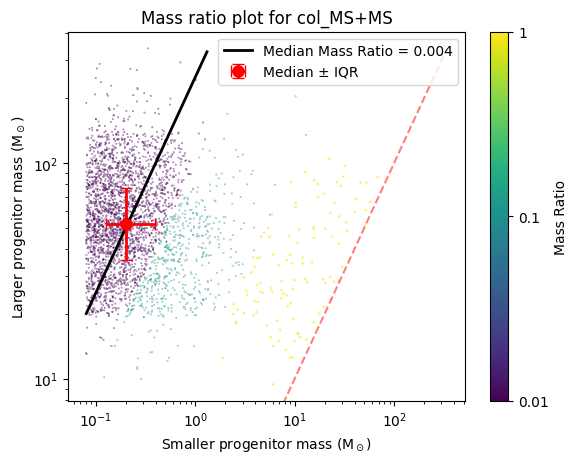

Smaller mass median: 0.209, Lower error: 0.088, Upper error: 0.220
Larger mass median: 26.156, Lower error: 5.685, Upper error: 14.058


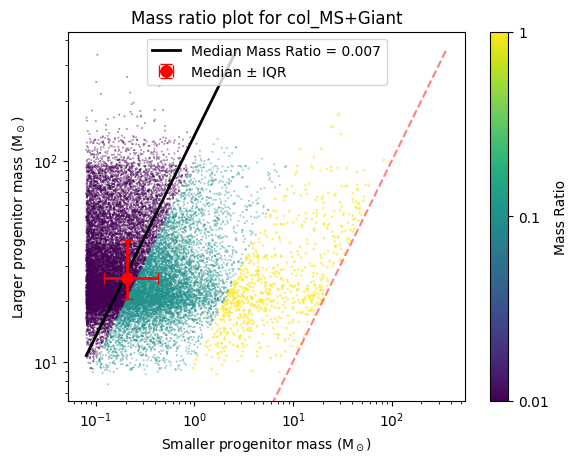

Smaller mass median: 19.631, Lower error: 7.150, Upper error: 9.238
Larger mass median: 30.099, Lower error: 11.660, Upper error: 20.653


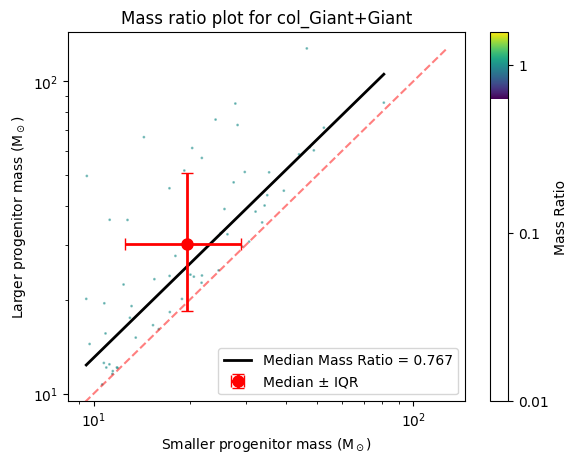

Smaller mass median: 1.182, Lower error: 0.024, Upper error: 0.037
Larger mass median: 12.880, Lower error: 1.469, Upper error: 1.429


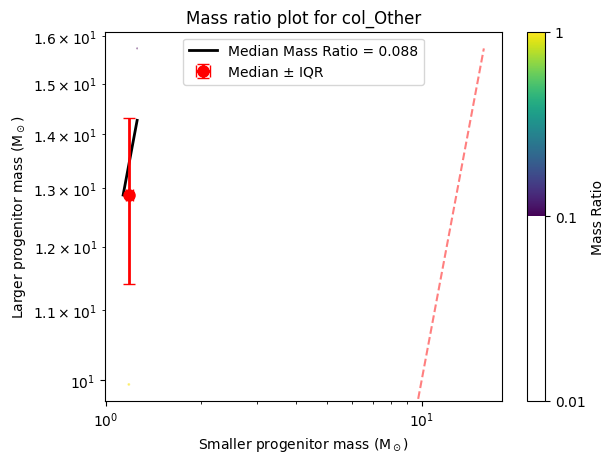

Smaller mass median: 0.195, Lower error: 0.062, Upper error: 0.045
Larger mass median: 136.050, Lower error: 7.073, Upper error: 13.445


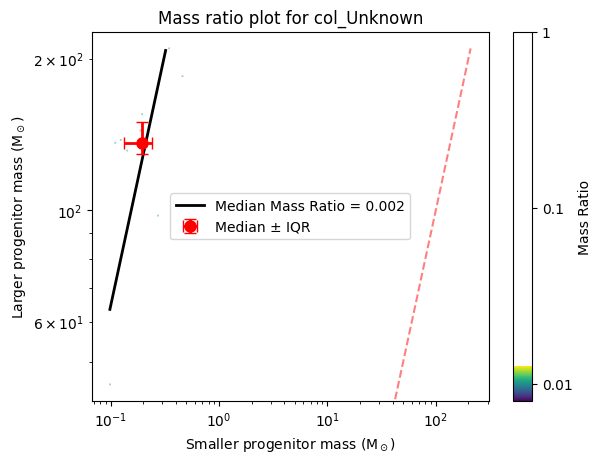

In [18]:
for name in names:
    col_plot = groups[name].copy()
    # col_plot = col_plot[col_plot['bbh_merger']==1] 
    plt.figure()
    col_plot = col_plot.reset_index()
    
    # Create categorical bins
    col_plot['q'] = pd.cut(
        col_plot['mass_ratio'], 
        bins=[0, 0.01, 0.1, 1.0], 
        labels=['0.01', '0.1', '1'],
        include_lowest=True
    )
    
    # Create conditional size and alpha arrays based on smaller_mass
    sizes = np.where(col_plot['mass_ratio'] < 0.1, 0.05, 1)  
    alphas = np.where(col_plot['mass_ratio'] < 0.1, 1, 0.5)  
    
    # Convert categorical to numerical codes 
    sc = plt.scatter(col_plot['smaller_mass'], col_plot['larger_mass'], 
                     c=col_plot['q'].cat.codes, cmap='viridis', 
                     s=sizes, alpha=alphas)
    
    maxi = col_plot['larger_mass'].max()
    plt.plot([0,maxi],[0,maxi],'r--',alpha=.5)
    
    # Create colorbar labels
    cb = plt.colorbar(sc)
    cb.set_label('Mass Ratio')
    cb.set_ticks([0, 1, 2])  
    cb.set_ticklabels(['0.01', '0.1', '1'])

    #making over all median line and pont
    median_line(col_plot)
    median_point(col_plot, color='red')
    
    plt.xlabel('Smaller progenitor mass (M$_\odot$)')
    plt.ylabel('Larger progenitor mass (M$_\odot$)')
    plt.yscale('log')
    plt.xscale('log')
    plt.title(f'Mass ratio plot for {name}')
    plt.legend()
    plt.show()


In [19]:
# over all median colored by continous q 
# for name in names:
#     col_plot = groups[name].copy()
#     plt.figure()
#     col_plot = col_plot.reset_index()
    
#     # Color directly using mass_ratio column
#     sc = plt.scatter(col_plot['smaller_mass'], col_plot['larger_mass'], 
#                      c=col_plot['mass_ratio'], cmap='viridis', alpha=.8, s=2)
    
#     # Get the range for drawing mass ratio lines
#     maxi = col_plot['larger_mass'].max()
#     mini = col_plot['larger_mass'].min()
    
#     # Create mass ratio lines at different thresholds
#     mass_ratios = [0.01, 0.1, 1.0]
#     larger_mass_range = np.linspace(mini, maxi, 100)
    
#     for ratio in mass_ratios:
#         smaller_mass_line = ratio * larger_mass_range
#         plt.plot(smaller_mass_line, larger_mass_range, 'r--', alpha=0.7, linewidth=1)
    
#     # Add labels for the mass ratio lines
#     for ratio in mass_ratios:
#         # Position label at a reasonable point on each line
#         label_larger_mass = maxi * 0.8  # Position at 80% of max
#         label_smaller_mass = ratio * label_larger_mass
#         plt.text(label_smaller_mass, label_larger_mass, f'q={ratio}', 
#                 rotation=45, color='red', fontsize=8, alpha=0.8)
    
#     # Create colorbar with continuous mass ratio values
#     cb = plt.colorbar(sc)
#     cb.set_label('Mass Ratio')
    
#     # Making overall median line and point
#     median_line(col_plot)
#     median_point(col_plot, color='red')
    
#     plt.xlabel('Smaller progenitor mass (M$_\odot$)')
#     plt.ylabel('Larger progenitor mass (M$_\odot$)')
#     plt.yscale('log')4b
#     plt.xscale('log')
#     plt.title(f'Mass ratio plot for {name}')
#     plt.legend()
#     plt.show()


# group median plots 

Smaller mass median: 0.166, Lower error: 0.052, Upper error: 0.104
Larger mass median: 74.855, Lower error: 26.353, Upper error: 25.365
Smaller mass median: 0.661, Lower error: 0.245, Upper error: 0.611
Larger mass median: 34.946, Lower error: 11.272, Upper error: 18.739
Smaller mass median: 15.807, Lower error: 8.838, Upper error: 9.312
Larger mass median: 42.691, Lower error: 14.847, Upper error: 29.559


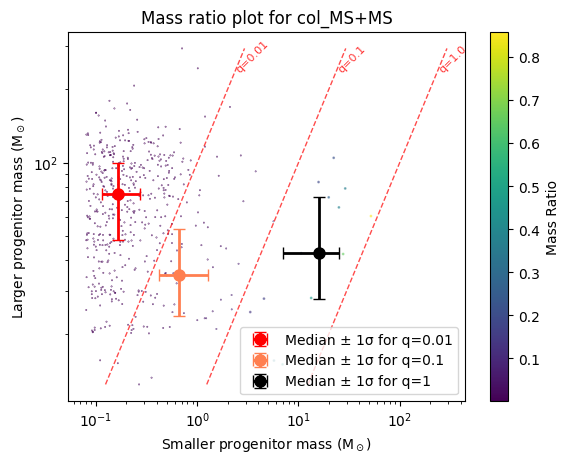

Smaller mass median: 0.149, Lower error: 0.042, Upper error: 0.076
Larger mass median: 42.608, Lower error: 15.765, Upper error: 20.569
Smaller mass median: 0.518, Lower error: 0.180, Upper error: 0.348
Larger mass median: 24.996, Lower error: 5.760, Upper error: 13.323
Smaller mass median: 8.702, Lower error: 4.317, Upper error: 10.590
Larger mass median: 31.154, Lower error: 11.851, Upper error: 21.893


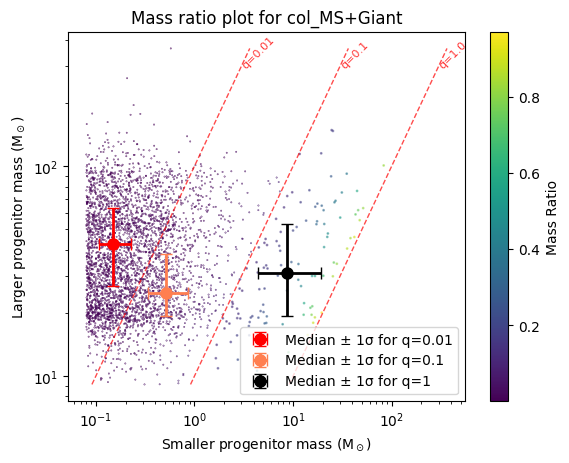

Smaller mass median: nan, Lower error: nan, Upper error: nan
Larger mass median: nan, Lower error: nan, Upper error: nan
Smaller mass median: nan, Lower error: nan, Upper error: nan
Larger mass median: nan, Lower error: nan, Upper error: nan
Smaller mass median: 27.728, Lower error: 14.979, Upper error: 6.504
Larger mass median: 35.960, Lower error: 17.726, Upper error: 25.547


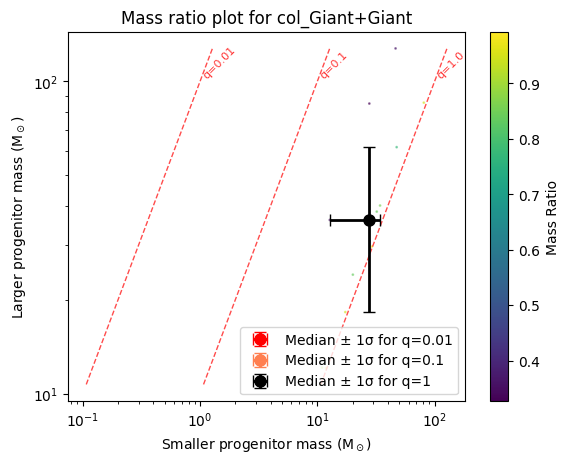

In [20]:
for name in names[:3]:
    col_plot = groups[name].copy()

    #toggle bbh merges
    col_plot = col_plot[col_plot['bbh_merger']==1] 

    plt.figure()
    col_plot = col_plot.reset_index()
    
    # Create categorical bins
    col_plot['q'] = pd.cut(
        col_plot['mass_ratio'], 
        bins=[0, 0.01, 0.1, 1.0], 
        labels=['0.01', '0.1', '1'],
        include_lowest=True
    )
    
    # conditional size and alpha arrays 
    sizes = np.where(col_plot['mass_ratio'] < 0.1, 0.09, 1)  
    alphas = np.where(col_plot['mass_ratio'] < 0.1, 1, 0.5)  

    # Convert categorical to numerical codes 
    sc = plt.scatter(col_plot['smaller_mass'], col_plot['larger_mass'], 
                     c=col_plot['mass_ratio'], cmap='viridis', alpha=alphas, s=sizes)




        # Get the range for drawing mass ratio lines
    maxi = col_plot['larger_mass'].max()
    mini = col_plot['larger_mass'].min()
    
    # Create mass ratio lines at different thresholds
    mass_ratios = [0.01, 0.1, 1.0]
    larger_mass_range = np.linspace(mini, maxi, 100)
    
    for ratio in mass_ratios:
        smaller_mass_line = ratio * larger_mass_range
        plt.plot(smaller_mass_line, larger_mass_range, 'r--', alpha=0.7, linewidth=1)
    
    # Add labels for the mass ratio lines
    for ratio in mass_ratios:
        # Position label at a reasonable point on each line
        label_larger_mass = maxi * 0.8  # Position at 80% of max
        label_smaller_mass = ratio * label_larger_mass
        plt.text(label_smaller_mass, label_larger_mass, f'q={ratio}', 
                rotation=45, color='red', fontsize=8, alpha=0.8)
        

    
    # Create colorbar labels
    cb = plt.colorbar(sc)
    cb.set_label('Mass Ratio')


    # Making overall median line
    # median_line(col_plot)
    
    # Plot separate median points for each category
    colors = ['red', 'coral', 'black']  # Different colors for each category
    for i, category in enumerate(['0.01', '0.1', '1']):
        category_data = col_plot[col_plot['q'] == category]
        median_point(category_data, 
                    color=colors[i], 
                    label=f'Median ± 1σ for q={category}', 
                    zorder=6)
    
    plt.xlabel('Smaller progenitor mass (M$_\odot$)')
    plt.ylabel('Larger progenitor mass (M$_\odot$)')
    plt.yscale('log')
    plt.xscale('log')
    plt.title(f'Mass ratio plot for {name}')
    plt.legend()
    plt.show()


In [21]:
ag_all_bh=pd.read_csv('Datasets/ag_all_bh.csv')
col.shape[0]/ag_all_bh.shape[0]

0.12326943942133815

# overall medians for col that lead to BH

Smaller mass median: 0.190, Lower error: 0.069, Upper error: 0.207
Larger mass median: 68.900, Lower error: 25.335, Upper error: 27.901


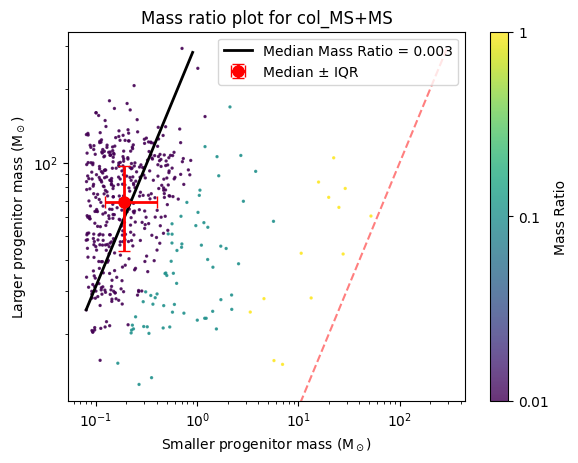

Smaller mass median: 0.214, Lower error: 0.087, Upper error: 0.225
Larger mass median: 35.106, Lower error: 12.412, Upper error: 21.139


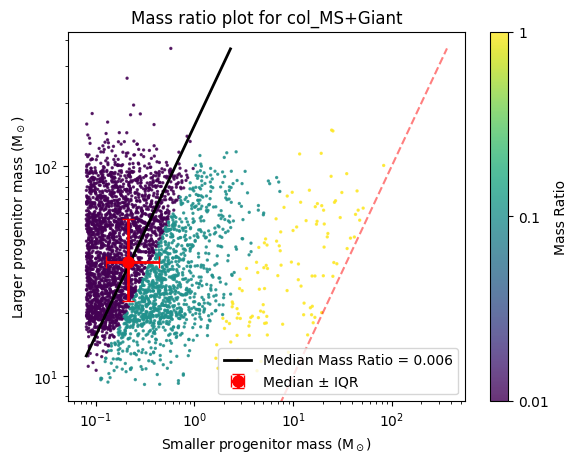

Smaller mass median: 27.728, Lower error: 14.979, Upper error: 6.504
Larger mass median: 35.960, Lower error: 17.726, Upper error: 25.547


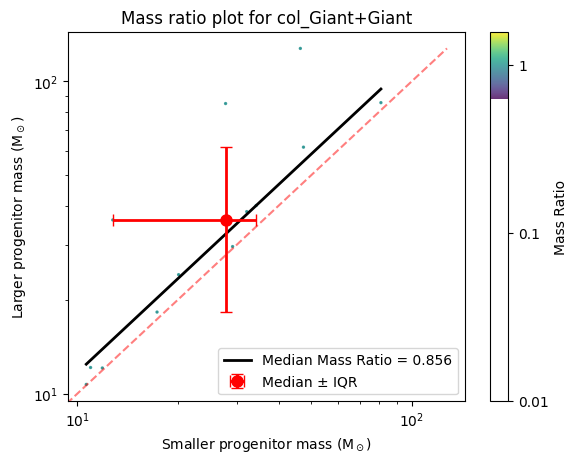

In [22]:
# over all median for col bh ---> merger
for name in names[:3]:
    col_plot = groups[name].copy()
    col_plot= col_plot[col_plot['bbh_merger'] == 1]
    plt.figure()
    col_plot = col_plot.reset_index()
    
    # Create categorical bins
    col_plot['q'] = pd.cut(
        col_plot['mass_ratio'], 
        bins=[0, 0.01, 0.1, 1.0], 
        labels=['0.01', '0.1', '1'],
        include_lowest=True
    )
    
    # Convert categorical to numerical codes 
    sc = plt.scatter(col_plot['smaller_mass'], col_plot['larger_mass'], 
                     c=col_plot['q'].cat.codes, cmap='viridis', alpha=.8, s=2)
    
    maxi = col_plot['larger_mass'].max()
    plt.plot([0,maxi],[0,maxi],'r--',alpha=.5)
    
    # Create colorbar labels
    cb = plt.colorbar(sc)
    cb.set_label('Mass Ratio')
    cb.set_ticks([0, 1, 2])  
    cb.set_ticklabels(['0.01', '0.1', '1'])

        
    #making over all median line and pont
    median_line(col_plot)
    median_point(col_plot, color='red')




    
    plt.xlabel('Smaller progenitor mass (M$_\odot$)')
    plt.ylabel('Larger progenitor mass (M$_\odot$)')
    plt.yscale('log')
    plt.xscale('log')
    plt.title(f'Mass ratio plot for {name}')
    plt.legend()
    plt.show()


# grouped medians for col that leads to bh

Smaller mass median: 0.166, Lower error: 0.052, Upper error: 0.104
Larger mass median: 74.855, Lower error: 26.353, Upper error: 25.365
Smaller mass median: 0.661, Lower error: 0.245, Upper error: 0.611
Larger mass median: 34.946, Lower error: 11.272, Upper error: 18.739
Smaller mass median: 15.807, Lower error: 8.838, Upper error: 9.312
Larger mass median: 42.691, Lower error: 14.847, Upper error: 29.559


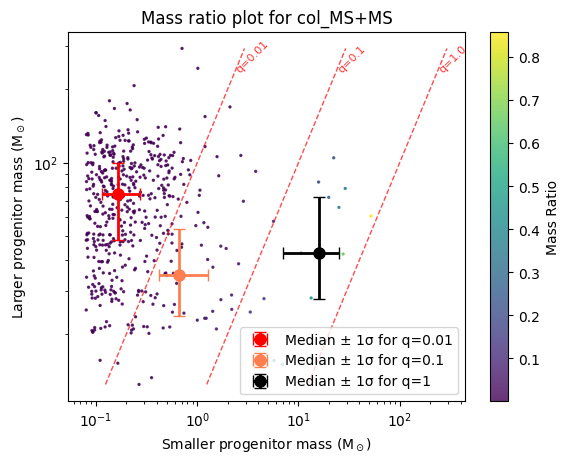

Smaller mass median: 0.149, Lower error: 0.042, Upper error: 0.076
Larger mass median: 42.608, Lower error: 15.765, Upper error: 20.569
Smaller mass median: 0.518, Lower error: 0.180, Upper error: 0.348
Larger mass median: 24.996, Lower error: 5.760, Upper error: 13.323
Smaller mass median: 8.702, Lower error: 4.317, Upper error: 10.590
Larger mass median: 31.154, Lower error: 11.851, Upper error: 21.893


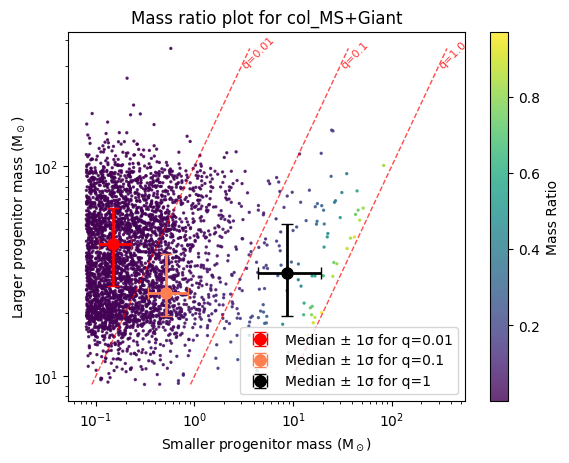

Smaller mass median: nan, Lower error: nan, Upper error: nan
Larger mass median: nan, Lower error: nan, Upper error: nan
Smaller mass median: nan, Lower error: nan, Upper error: nan
Larger mass median: nan, Lower error: nan, Upper error: nan
Smaller mass median: 27.728, Lower error: 14.979, Upper error: 6.504
Larger mass median: 35.960, Lower error: 17.726, Upper error: 25.547


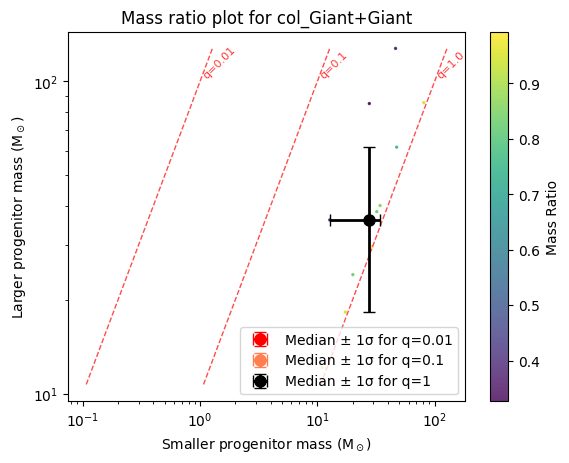

In [23]:
for name in names[:3]:
    col_plot = groups[name].copy()
    plt.figure()
    col_plot= col_plot[col_plot['bbh_merger'] == 1]
    col_plot = col_plot.reset_index()
    
    # Create categorical bins
    col_plot['q'] = pd.cut(
        col_plot['mass_ratio'], 
        bins=[0, 0.01, 0.1, 1.0], 
        labels=['0.01', '0.1', '1'],
        include_lowest=True
    )
    
    # Convert categorical to numerical codes 
    sc = plt.scatter(col_plot['smaller_mass'], col_plot['larger_mass'], 
                     c=col_plot['mass_ratio'], cmap='viridis', alpha=.8, s=2)




        # Get the range for drawing mass ratio lines
    maxi = col_plot['larger_mass'].max()
    mini = col_plot['larger_mass'].min()
    
    # Create mass ratio lines at different thresholds
    mass_ratios = [0.01, 0.1, 1.0]
    larger_mass_range = np.linspace(mini, maxi, 100)
    
    for ratio in mass_ratios:
        smaller_mass_line = ratio * larger_mass_range
        plt.plot(smaller_mass_line, larger_mass_range, 'r--', alpha=0.7, linewidth=1)
    
    # Add labels for the mass ratio lines
    for ratio in mass_ratios:
        # Position label at a reasonable point on each line
        label_larger_mass = maxi * 0.8  # Position at 80% of max
        label_smaller_mass = ratio * label_larger_mass
        plt.text(label_smaller_mass, label_larger_mass, f'q={ratio}', 
                rotation=45, color='red', fontsize=8, alpha=0.8)
        

    
    # Create colorbar labels
    cb = plt.colorbar(sc)
    cb.set_label('Mass Ratio')


    # Making overall median line
    # median_line(col_plot)
    
    # Plot separate median points for each category
    colors = ['red', 'coral', 'black']  # Different colors for each category
    for i, category in enumerate(['0.01', '0.1', '1']):
        category_data = col_plot[col_plot['q'] == category]
        median_point(category_data, 
                    color=colors[i], 
                    label=f'Median ± 1σ for q={category}', 
                    zorder=6)
    
    plt.xlabel('Smaller progenitor mass (M$_\odot$)')
    plt.ylabel('Larger progenitor mass (M$_\odot$)')
    plt.yscale('log')
    plt.xscale('log')
    plt.title(f'Mass ratio plot for {name}')
    plt.legend()
    plt.show()


# plotting bh masses for each group

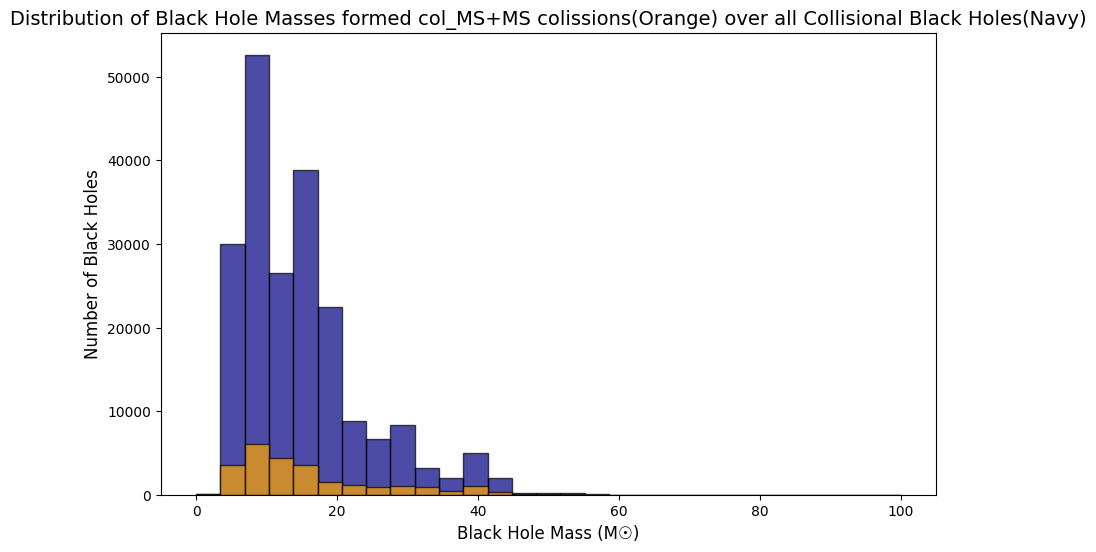

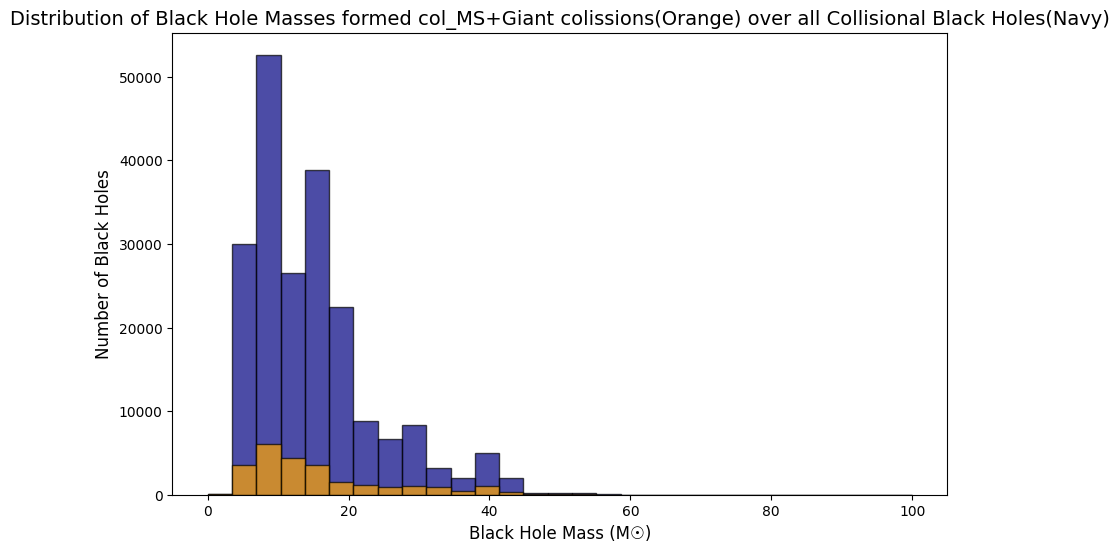

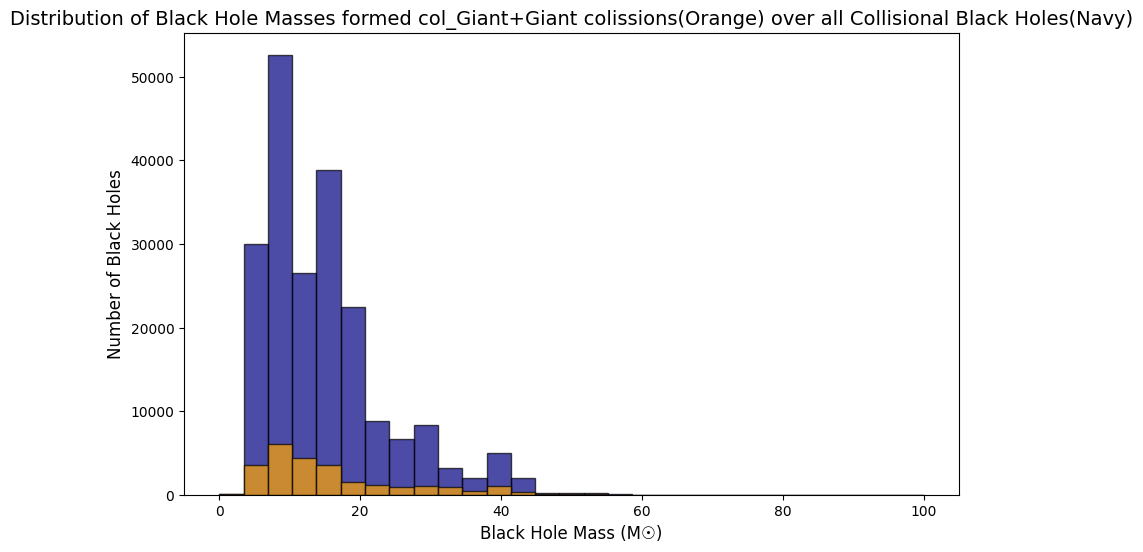

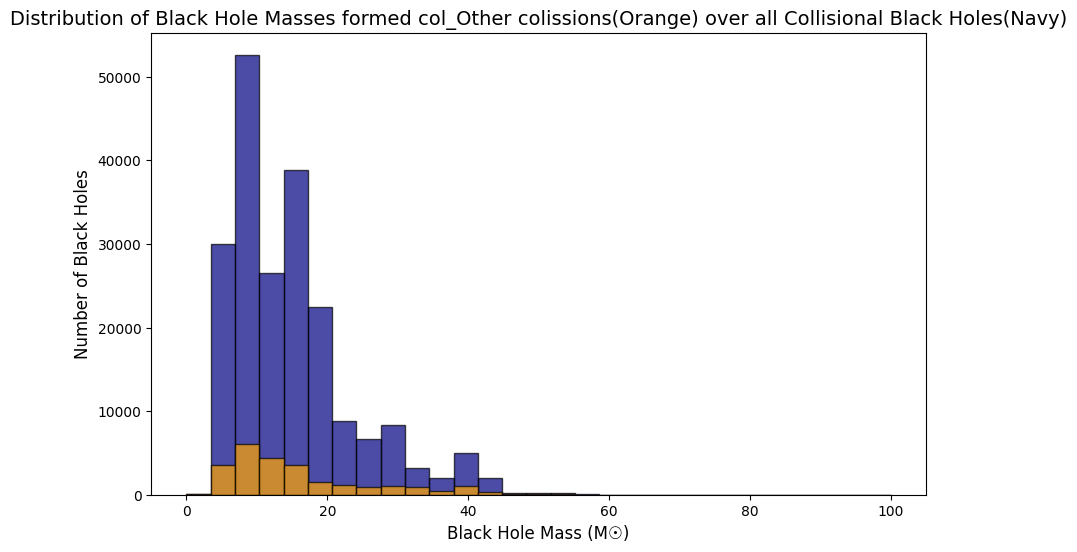

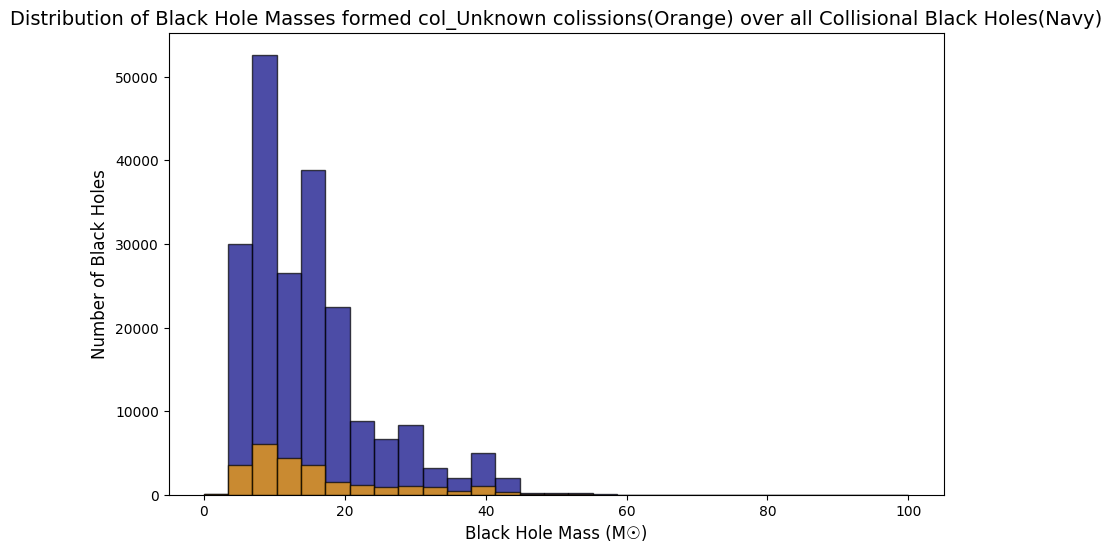

In [24]:

for name in names:
    plt.figure(figsize=(10, 6))
    bins = np.linspace(0, 100, 30)  # Create bins upto 100 m sun
    plt.hist(ag_all_bh['bh_mass'], bins=bins, color='navy', alpha=0.7, edgecolor='black')
    plt.xlabel('Black Hole Mass (M☉)', fontsize=12)
    plt.ylabel('Number of Black Holes', fontsize=12)
    plt.title(f'Distribution of Black Hole Masses formed {name} colissions(Orange) over all Collisional Black Holes(Navy)', fontsize=14)
    col_bh_0= groups[name]
    bins2 = np.linspace(0, 100, 30)  # Create bins upto 100 m sun
    plt.hist(col['bh_mass'], bins=bins2, color='orange', alpha=0.7, edgecolor='black')
    
    # plt.yscale('log')
    plt.show()

# Significant collisions only

In [25]:
sig_groups = {}

for name, df in groups.items():
    # Make a filtered copy: keep rows where mass_ratio >= 0.1
    sig_groups[name] = df[df['mass_ratio'] >= 0.1].copy()



In [37]:
sig_group_list=[]
for name in names:

    print(f'Group params {name}')
    sig_group_list.append(sumarise_col(sig_groups[name].copy())
)


Group params col_MS+MS
-------------------------
count      111            
percentage 0.43422133552399955
avg_smaller_mass 14.678350180180182
avg_larger_mass 38.52634675675676
avg_mass_ratio 0.3973386360693619
avg_merged_mass 53.07571351351351
median_smaller_mass 9.7258         
median_larger_mass 29.587         
median_mass_ratio 0.3277646014887684
median_merged_mass 41.3856        
-------------------------
Group params col_MS+Giant
-------------------------
count      753            
percentage 2.9456636545006454
avg_smaller_mass 10.128118794156707
avg_larger_mass 29.294674183266935
avg_mass_ratio 0.33393940232025415
avg_merged_mass 39.082337715803455
median_smaller_mass 5.41897        
median_larger_mass 22.2729        
median_mass_ratio 0.2237552017107849
median_merged_mass 29.1714        
-------------------------
Group params col_Giant+Giant
-------------------------
count      58             
percentage 0.22689042757109887
avg_smaller_mass 23.08787172413793
avg_larger_mass 36.

In [38]:
sig_group_sum = pd.DataFrame(sig_group_list)
sig_group_sum= sig_group_sum.set_axis(names).round(3)
sig_group_sum['sig_percent']


,count,percentage,avg_smaller_mass,avg_larger_mass,avg_mass_ratio,avg_merged_mass,median_smaller_mass,median_larger_mass,median_mass_ratio,median_merged_mass
col_MS+MS,111,0.434,14.678,38.526,0.397,53.076,9.726,29.587,0.328,41.386
col_MS+Giant,753,2.946,10.128,29.295,0.334,39.082,5.419,22.273,0.224,29.171
col_Giant+Giant,58,0.227,23.088,36.518,0.718,58.846,19.631,30.100,0.767,46.013
col_Other,1,0.004,1.182,9.942,0.119,11.109,1.182,9.942,0.119,11.109
col_Unknown,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# testing code

In [27]:
col_test=groups[names[0]]


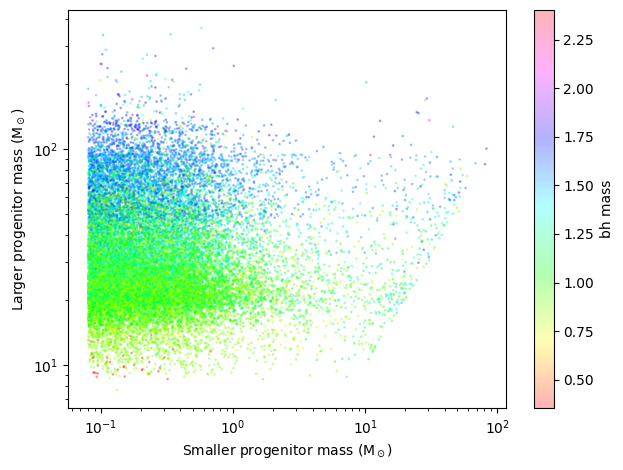

In [28]:
#PLOTTING UNLABELLED COLISIONS
col_plot = ag_col_bh.copy()
col_plot = col_plot.sort_values('time_x',ascending=False)[3:] #dropping the 3 100Myr+ events

plt.figure()
sc = plt.scatter(col_plot['smaller_mass'], col_plot['larger_mass'], c=np.log10(col_plot['bh_mass']),cmap='hsv', alpha=.3, s=1)
plt.xlabel('Smaller progenitor mass (M$_\odot$)')
plt.ylabel('Larger progenitor mass (M$_\odot$)')
plt.yscale('log')
plt.xscale('log')

cb = plt.colorbar(sc); cb.set_label('bh mass')
plt.tight_layout()
plt.show()

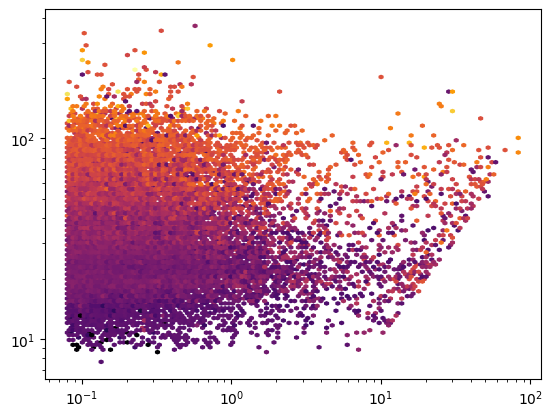

In [29]:
plt.hexbin(col_plot['smaller_mass'], col_plot['larger_mass'],C=np.log10(col_plot['bh_mass']),
           gridsize=120,cmap='inferno',xscale='log',yscale='log')

In [30]:
ag_all_bh

,time,r,binary,ID,zams_m,m_progenitor,bh_mass,bh_spin,birth_kick,bbh_merger,model
0,3.646477,0.030642,1,1747662,0.000000,36.57920,32.92130,0.0,0.0,0,data\N16rv0.5rg2.0Z0.002
1,3.658199,0.671370,0,1251321,138.870000,46.50210,41.85190,0.0,1.0,1,data\N16rv0.5rg2.0Z0.002
2,3.664091,1.776460,0,1522758,137.253000,46.49440,41.84500,0.0,1.0,1,data\N16rv0.5rg2.0Z0.002
3,3.665068,0.046309,1,1730245,0.000000,36.36410,32.72770,0.0,0.0,0,data\N16rv0.5rg2.0Z0.002
4,3.667156,0.069671,1,1713342,0.000000,36.53060,32.87760,0.0,0.0,0,data\N16rv0.5rg2.0Z0.002
...,...,...,...,...,...,...,...,...,...,...,...
207370,17.584706,1.914572,0,901838,58.609600,8.76791,7.63069,0.0,1.0,0,data\N8.0rv4.0rg8.0Z0.02
207371,17.584706,5.089760,0,837081,0.289053,8.91520,7.75925,0.0,1.0,0,data\N8.0rv4.0rg8.0Z0.02
207372,17.584706,7.010080,0,809279,0.197540,9.11295,7.93182,0.0,1.0,0,data\N8.0rv4.0rg8.0Z0.02
207373,17.584706,7.032760,0,815106,0.427445,9.38681,8.17049,0.0,1.0,0,data\N8.0rv4.0rg8.0Z0.02


# mass ratio plot with denisty histogram

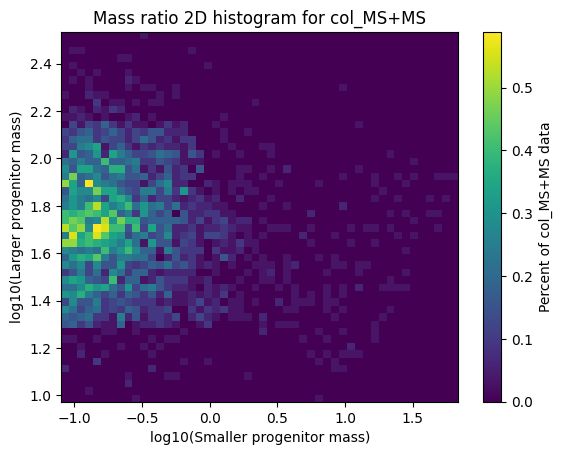

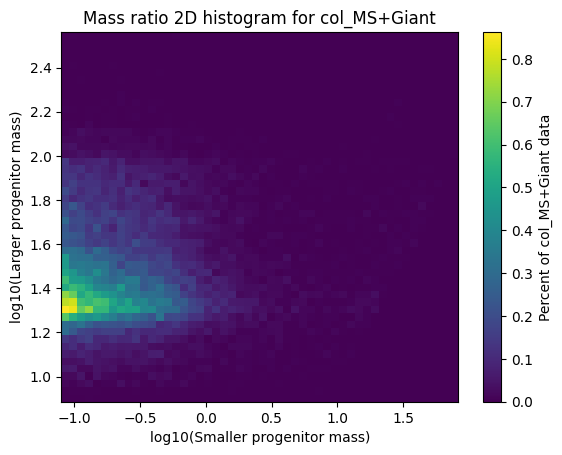

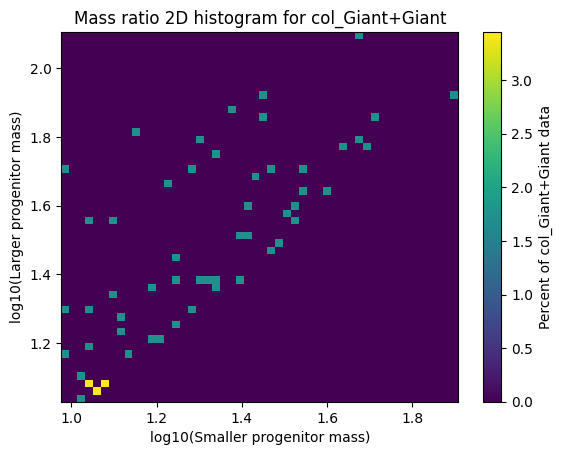

In [31]:
import numpy as np
import matplotlib.pyplot as plt

for name in names[:3]:
    col_plot = groups[name].copy()


    #leads to mergers toggle
    # col_plot= col_plot[col_plot['bbh_merger']==1]



    plt.figure()
    x = np.log10(col_plot['smaller_mass'])
    y = np.log10(col_plot['larger_mass'])
    H, xedges, yedges = np.histogram2d(x, y, bins=50)
    
    # Convert to percent
    H_percent = (H / H.sum()) * 100

    
    # Plot percent 2D histogram
    mesh = plt.imshow(
        H_percent.T,
        origin='lower',
        aspect='auto',
        cmap='viridis',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        vmin=0,
        vmax=H_percent.max()  
    )
    
    cb = plt.colorbar(mesh)
    plt.xlabel('log10(Smaller progenitor mass)')
    plt.ylabel('log10(Larger progenitor mass)')
    cb.set_label(f'Percent of {name} data')

    plt.title(f'Mass ratio 2D histogram for {name}')
    plt.show()


In [32]:
model_list.groupby('N').count()

,rv,rg,Z,model_name,path
N,,,,,
2.0,36,36,36,36,36
4.0,36,36,36,36,36
8.0,36,36,36,36,36
16.0,33,33,33,33,33
32.0,4,4,4,4,4


In [33]:
ag_bh_merger = pd.read_csv('Datasets/ag_bh_merge.csv')

In [34]:
ag_bh_merger

,model_num,rv,rg,Z,N,merger_time,id1,id2,m1,m2,...,v_kick,v_esc,merger_channel,id3,m3,spin3,a_final,e_final,e_10hz,model_path
0,149.0,2.0,20.0,0.0020,1.0,1462.024342,11218267.0,11376179.0,39.066200,64.153300,...,615.00700,124.471,2.0,11218267.0,97.0416,0.789834,0.039087,0.974112,-1.000000,data\N1.0rv2.0rg20.0Z0.002
1,149.0,2.0,20.0,0.0020,1.0,1458.362462,3405159.0,10713487.0,78.605800,36.679700,...,202.16400,142.628,2.0,3405159.0,110.8000,0.615818,0.006233,0.226507,-1.000000,data\N1.0rv2.0rg20.0Z0.002
2,149.0,2.0,20.0,0.0020,1.0,1450.360482,409091.0,12548057.0,74.607300,77.556700,...,1905.42000,138.885,4.0,10909092.0,142.0570,0.810091,0.000426,0.765269,-1.000000,data\N1.0rv2.0rg20.0Z0.002
3,149.0,2.0,20.0,0.0020,1.0,1428.545907,2542109.0,5496015.0,68.259400,73.410100,...,1252.78000,137.462,2.0,2542109.0,136.5880,0.533834,0.006005,0.500509,-1.000000,data\N1.0rv2.0rg20.0Z0.002
4,149.0,2.0,20.0,0.0020,1.0,1427.815813,3405159.0,11889850.0,41.667500,40.924400,...,5.17841,136.894,2.0,3405159.0,78.6058,0.686416,0.004472,0.426924,-1.000000,data\N1.0rv2.0rg20.0Z0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14343,146.0,2.0,20.0,0.0002,32.0,4129.412471,869335.0,1207646.0,30.194179,28.958173,...,-1.00000,-1.000,1.0,-1.0,-1.0000,-1.000000,0.364832,0.867927,3231.504455,data\N32rv2.0rg20.0Z0.0002
14344,147.0,1.0,20.0,0.0200,32.0,400.218570,3293228.0,4047500.0,7.778680,14.824300,...,150.56000,100.227,2.0,3293228.0,21.6853,0.632325,0.005325,0.835795,-1.000000,data\N32rv1.0rg20.0Z0.02
14345,147.0,1.0,20.0,0.0200,32.0,394.547323,706533.0,4210135.0,28.415000,27.543800,...,555.59600,115.510,3.0,4066534.0,53.4775,0.647259,0.000152,0.818534,-1.000000,data\N32rv1.0rg20.0Z0.02
14346,147.0,1.0,20.0,0.0200,32.0,324.672727,623145.0,1451794.0,13.309600,14.833100,...,31.00740,118.910,3.0,3983145.0,26.7911,0.684856,0.000078,0.788432,-1.000000,data\N32rv1.0rg20.0Z0.02


In [35]:
ag_col_bh

,time_x,collision_type,idm,mm,id1,m1,id2,m2,r_x,typem,...,binary,ID,zams_m,m_progenitor,bh_mass,bh_spin,birth_kick,bbh_merger,model,int_type
0,11.565179,single-single,1680002,33.8986,1680001,33.7704,470820,0.129842,0.038822,4,...,0,1680002,0.000000,17.89330,16.09650,0.0,1.00000,0,data\N16rv0.5rg2.0Z0.002,MS+Giant
1,7.978654,single-single,1680061,133.8740,1680060,179.9130,299190,0.394966,0.013368,4,...,1,1680061,0.000000,33.00390,29.70350,0.0,0.00000,0,data\N16rv0.5rg2.0Z0.002,MS+Giant
2,3.710148,single-single,1680133,110.5980,1680132,110.4200,261872,0.179723,0.025530,4,...,1,1680133,0.000000,35.19190,31.67270,0.0,0.00000,0,data\N16rv0.5rg2.0Z0.002,MS+Giant
3,4.100341,single-single,1680220,41.3707,1680219,41.2697,328483,0.105145,0.052498,4,...,0,1680220,0.341818,34.12200,30.70980,0.0,1.00000,0,data\N16rv0.5rg2.0Z0.002,MS+Giant
4,3.849036,single-single,1680292,52.0011,1680291,51.8734,137163,0.133144,0.041029,4,...,0,1680292,0.169725,40.61420,36.55280,0.0,1.00000,1,data\N16rv0.5rg2.0Z0.002,MS+Giant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25558,7.467068,single-single,867397,27.4788,27397,27.2059,34148,0.274166,0.809076,4,...,0,867397,1.377720,29.83110,12.91490,0.0,196.38100,0,data\N8.0rv4.0rg8.0Z0.002,MS+Giant
25559,8.195550,single-single,935010,21.1569,95010,21.0637,260784,0.094146,1.787344,4,...,0,935010,0.376952,29.08860,11.89070,0.0,89.37041,0,data\N8.0rv4.0rg8.0Z0.002,MS+Giant
25560,8.195550,single-single,1021125,23.4548,239877,23.3603,181125,0.095204,2.219268,4,...,0,1021125,0.000000,28.60760,11.48710,0.0,149.45210,0,data\N8.0rv4.0rg8.0Z0.002,MS+Giant
25561,6.479118,single-single,901838,26.2744,61838,26.0639,69692,0.210457,0.995484,1,...,0,901838,58.609600,8.76791,7.63069,0.0,1.00000,0,data\N8.0rv4.0rg8.0Z0.02,MS+MS
